# Setup

In [27]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../../code/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline


Default libraries loaded.


# Paths and Parameters

In [28]:
outfn = '../../data/sla_to_woa.nc'

# Read Data

In [29]:
# SLA
ds_SLA = xr.open_dataset('../../data/sla_processed.nc')
ds_SLA

<xarray.Dataset>
Dimensions:           (day_time: 10013, lat: 138, loc_list: 7, lon: 216, month: 12, no_stations: 574, time: 329)
Coordinates:
  * lon               (lon) float64 48.62 48.88 49.12 ... 101.9 102.1 102.4
  * lat               (lat) float64 -1.375 -1.125 -0.875 ... 32.38 32.62 32.88
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * day_time          (day_time) datetime64[ns] 1993-01-01 ... 2020-05-31
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 572.0 573.0 574.0
  * loc_list          (loc_list) int64 0 80 201 291 382 491 573
Data variables:
    daily_sla         (day_time, lat, lon) float64 ...
    mon_sla           (time, lat, lon) float64 ...
    mon_sla_mon_clim  (month, lat, lon) float64 ...
    mon_sla_mon_anom  (time, lat, lon) float64 ...
    sta_loninds       (no_stations) int64 ...
    sta_latinds       (no_stations) int64 ...
    sta_lon           (no

In [30]:
# WOA
infn_WOA = '../../data/woa_processed.nc'

ds_WOA = xr.open_dataset(infn_WOA)
ds_WOA

<xarray.Dataset>
Dimensions:                      (coastal_loc: 1925, coastal_pos: 439, depth: 57, lat: 35, lon: 55, lonmin,lonmax,latmin,latmax: 4, month: 12)
Coordinates:
  * month                        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                        (depth) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                          (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                          (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
  * coastal_loc                  (coastal_loc) int64 0 1 2 3 ... 1922 1923 1924
  * coastal_pos                  (coastal_pos) int64 0 1 2 3 ... 435 436 437 438
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    temp                         (month, depth, lat, lon) float64 ...
    psal                         (month, depth, lat, lon) float64 ...
    doxy                         (month, depth, lat, lon) float64 ...
    nitrate                      (month, depth, lat

# Regrid

In [31]:
xx,yy = np.meshgrid(ds_SLA.lon,ds_SLA.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_WOA,yy_WOA = np.meshgrid(ds_WOA.lon,ds_WOA.lat)

mon_sla_mon_anom_WOA = np.zeros((len(ds_SLA.time),len(ds_WOA.lat),len(ds_WOA.lon)))*np.nan

for tt in tqdm(range(len(ds_SLA.time))):

    temp_sla = np.array(ds_SLA.mon_sla_mon_anom[tt,:,:])

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    temp_values = temp_sla.flatten()

    mon_sla_mon_anom_WOA[tt,:,:] = griddata(points, temp_values, (xx_WOA,yy_WOA) ,method='linear')

ds_out = xr.Dataset(coords={'time': ds_SLA.time,
                        'lon': ds_WOA.lon,
                        'lat': ds_WOA.lat})
coords = [ds_SLA.time,ds_WOA.lat,ds_WOA.lon]
dims = ['time','lat','lon']

# add to dataset
ds_out['mon_sla_mon_anom'] = xr.DataArray(mon_sla_mon_anom_WOA,dims = dims,coords = coords)

100%|██████████| 329/329 [02:23<00:00,  2.31it/s]


In [32]:
xx,yy = np.meshgrid(ds_SLA.lon,ds_SLA.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_WOA,yy_WOA = np.meshgrid(ds_WOA.lon,ds_WOA.lat)

mon_sla_mon_clim_WOA = np.zeros((len(ds_WOA.month),len(ds_WOA.lat),len(ds_WOA.lon)))*np.nan

for tt in tqdm(range(len(ds_WOA.month))):

    temp_sla = np.array(ds_SLA.mon_sla_mon_clim[tt,:,:])

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    temp_values = temp_sla.flatten()

    mon_sla_mon_clim_WOA[tt,:,:] = griddata(points, temp_values, (xx_WOA,yy_WOA) ,method='linear')

# ds_out = xr.Dataset(coords={'month': ds_WOA.month,
#                         'lon': ds_WOA.lon,
#                         'lat': ds_WOA.lat})
coords = [ds_WOA.month,ds_WOA.lat,ds_WOA.lon]
dims = ['month','lat','lon']

# add to dataset
ds_out['mon_sla_mon_clim'] = xr.DataArray(mon_sla_mon_clim_WOA,dims = dims,coords = coords)



100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


# Sample Plot

Text(0.5, 1.0, 'Original')

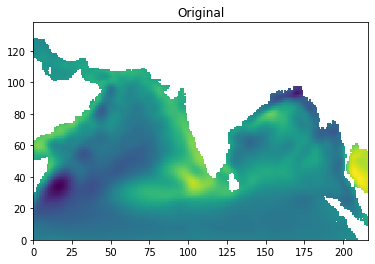

In [33]:
plt.pcolor(ds_SLA.mon_sla_mon_clim[0,:,:])
plt.title('Original')

Text(0.5, 1.0, 'Regridded')

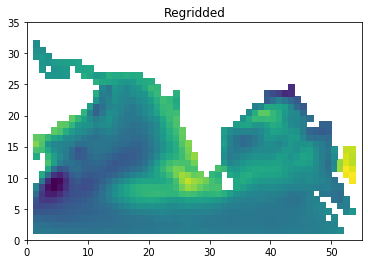

In [34]:
plt.pcolor(ds_out.mon_sla_mon_clim[0,:,:])
plt.title('Regridded')

# SAVE

In [35]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:           (lat: 35, lon: 55, month: 12, time: 329)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2020-05-01
  * lon               (lon) float32 48.5 49.5 50.5 51.5 ... 100.5 101.5 102.5
  * lat               (lat) float32 -1.5 -0.5 0.5 1.5 ... 29.5 30.5 31.5 32.5
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mon_sla_mon_anom  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    mon_sla_mon_clim  (month, lat, lon) float64 nan nan nan nan ... nan nan nan